
XGBoost Evaluation:
Accuracy: 0.9994
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.84      0.80      0.82       118

    accuracy                           1.00     70932
   macro avg       0.92      0.90      0.91     70932
weighted avg       1.00      1.00      1.00     70932

ROC-AUC Score: 0.9777

XGBoost Evaluation with Adjusted Threshold:
Optimal Threshold: 0.8810
Adjusted Accuracy: 0.9995
Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     70814
           1       0.95      0.77      0.85       118

    accuracy                           1.00     70932
   macro avg       0.97      0.89      0.93     70932
weighted avg       1.00      1.00      1.00     70932

ROC-AUC Score with Adjusted Threshold: 0.9777

Logistic Regression Evaluation:
Accuracy: 0.9876
Classification Report

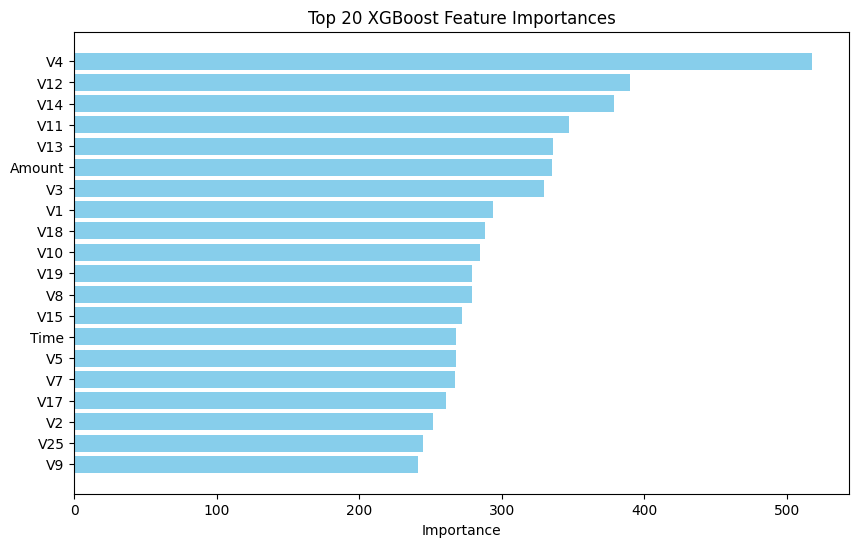

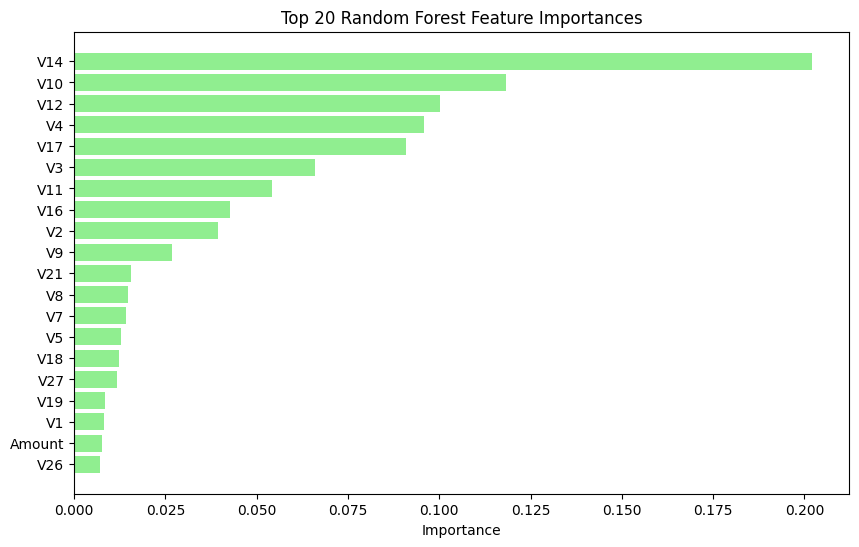

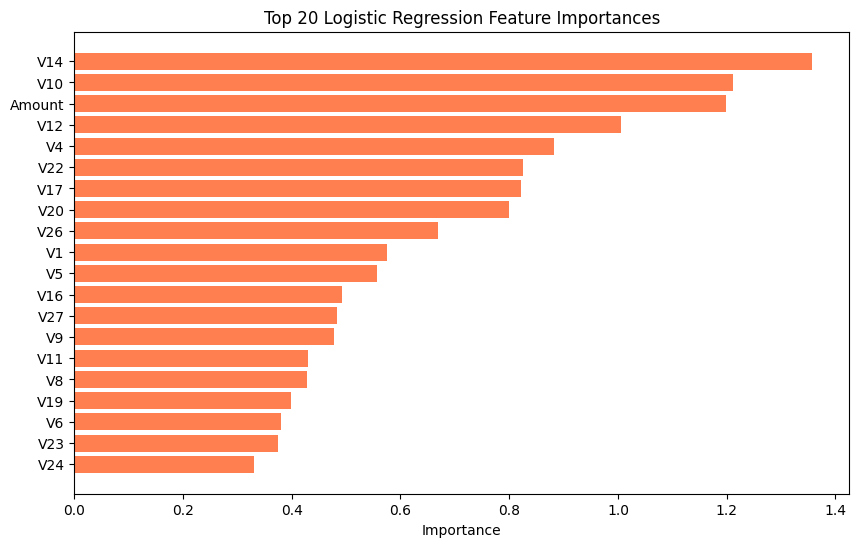

: 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# Load the dataset
dataset1 = pd.read_csv('dataset1-MLG/creditcard.csv')
dataset1.drop_duplicates(inplace=True)

# Ensure 'Time' and 'Amount' columns are numeric
numeric_columns = ['Time', 'Amount']
for col in numeric_columns:
    dataset1[col] = pd.to_numeric(dataset1[col], errors='coerce')

# Drop rows with missing values
dataset1.dropna(inplace=True)

# Define features (X) and target (y)
X = dataset1.drop(columns=['Class'])  # Features
y = dataset1['Class']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Train the XGBoost Model
clf_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.75,
    colsample_bytree=0.75,
    random_state=42
)
clf_xgb.fit(X_train_resampled, y_train_resampled)

### Train the Logistic Regression Model
model_log_reg = LogisticRegression(max_iter=10000, random_state=42)
model_log_reg.fit(X_train_resampled, y_train_resampled)

### Train the Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_resampled, y_train_resampled)

### Evaluation Functions

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    optimal_idx = np.argmax(2 * precision * recall / (precision + recall))
    optimal_threshold = thresholds[optimal_idx]

    y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

    print(f"\n{model_name} Evaluation with Adjusted Threshold:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Adjusted Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
    print("Classification Report with Adjusted Threshold:\n", classification_report(y_test, y_pred_adjusted))
    print(f"ROC-AUC Score with Adjusted Threshold: {roc_auc_score(y_test, y_pred_proba):.4f}")

### Plotting Functions

def plot_xgboost_feature_importance(model, X_train, top_n=20):
    xgb_importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': list(xgb_importance.keys()), 'Importance': list(xgb_importance.values())})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} XGBoost Feature Importances')
    plt.xlabel('Importance')
    plt.show()

def plot_rf_feature_importance(model, X_train, top_n=20):
    rf_importance = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.show()

def plot_logistic_regression_coefficients(model, X_train, top_n=20):
    coef = model.coef_.flatten()
    feature_names = X_train.columns
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
    coef_df['Importance'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Importance'], color='coral')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Logistic Regression Feature Importances')
    plt.xlabel('Importance')
    plt.show()

### Evaluate Models
evaluate_model(clf_xgb, X_test, y_test, model_name="XGBoost")
evaluate_model(model_log_reg, X_test, y_test, model_name="Logistic Regression")
evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")

### Plot Feature Importances
plot_xgboost_feature_importance(clf_xgb, X_train, top_n=20)
plot_rf_feature_importance(rf_model, X_train, top_n=20)
plot_logistic_regression_coefficients(model_log_reg, X_train, top_n=20)
